In [1]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False



import sys,os,pdb,copy,pickle
from importlib import reload
# import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
sys.path.append('/mnt/home/szheng/projects/place_variability/code')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp


import change_point_analysis as cpa
import change_point_plot as cpp

import place_field_analysis as pf

import switch_analysis_one_session as saos
reload(saos)

import process_central_arm as pca 
import change_point_analysis_central_arm_seperate as cpacas

import misc
reload(misc)
from misc import get_nth_key, get_nth_val

67 sessions!
67 sessions!


In [2]:
import database
db = database.db

subdb = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)
subdb = subdb.query('ntrials>=20&n_neurons>=50')
to_exclude_sess = ['e16_3m2_211211']
subdb=subdb.loc[~subdb['sess_name'].isin(to_exclude_sess)]


import pf_recombine_central as pfrc
import fr_map_one_session as fmos
import switch_detection_one_session as sdos
import get_all_switch_add_metrics as gasam

import preprocess_one_session as prepos
import sw_and_int_one_sess as sios

/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [3]:
figdir = '/mnt/home/szheng/ceph/place_variability/fig/paper/figure_disinhibition'
figdir = misc.get_or_create_subdir(figdir)

In [4]:
data_dir = '/mnt/home/szheng/ceph/place_variability/data/paper'
savefn_full = os.path.join(data_dir,'per_field_metrics_shtest_with_1cp.p')
per_field_metrics_all=pickle.load(open(savefn_full,'rb'))

# gpb=per_field_metrics_all.groupby(level=(0,1,4),sort=False)
# fr_nrem_all = []
# for k,val in gpb:
#     fr_nrem=np.ones(val.shape[0]) * cell_metrics_df_all.loc[k,'firingRate_NREMstate']
#     fr_nrem_all.append(pd.Series(fr_nrem,index=val.index))
# fr_nrem_all = pd.concat(fr_nrem_all,axis=0)
    

# per_field_metrics_all['fr_nrem']=fr_nrem_all

In [5]:
fn = 'prepped_data_agg.p'
fn_full = os.path.join(data_dir,fn)
prepped_data_agg = pickle.load(open(fn_full,'rb'))

all_fields_recombined_all = prepped_data_agg['all_fields_recombined_all']
pf_params_recombined_all=  prepped_data_agg['pf_params_recombined_all']
fr_map_trial_df_all= prepped_data_agg['fr_map_trial_df_all']
occu_map_all = prepped_data_agg['occu_map_all']
fr_map_all = prepped_data_agg['fr_map_all']

pval_all = prepped_data_agg['pval_all']
X_pwc_all = prepped_data_agg['X_pwc_all']
X_raw_all = prepped_data_agg['X_raw_all']
changes_df_all = prepped_data_agg['changes_df_all']
var_res_all_test = prepped_data_agg['var_res_all']
# corr_all = prepped_data_agg['corr_all']
all_sw_d_all = prepped_data_agg['all_sw_d_all']
all_sw_with_metrics_d_all = prepped_data_agg['all_sw_with_metrics_d_all']
best_n_all_test = prepped_data_agg['best_n_all']
spk_beh_df_all = prepped_data_agg['spk_beh_df_all']

ntrials_per_tt=fr_map_trial_df_all.groupby(level=(0,1,2,3)).apply(lambda x:x.dropna(axis=1,how='all').shape[1])
ntrials_mask = ntrials_per_tt.groupby(level=(0,1,2)).apply(lambda x:(x>=7).all()) 


In [6]:
import switch_detection_sweep_penalty_one_session as sdspos
import get_all_switch_add_metrics_pen as gasamp
reload(gasamp)
pen=0.5#0.3#0.3#0.5

best_n_all = {}
X_pwc_all={}
X_raw_all={}
changes_df_all={}
var_res_all={}
corr_all = {}
p_corr_all = {}
all_sw_d_all={}
all_sw_with_metrics_d_all = {}

for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_res_pelt = sdspos.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    
    sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=False,load_only=True,dosave=False)
    if sw_info_res_pelt is None:
        sw_info_res_pelt=gasamp.main(data_dir_full,force_reload=True,load_only=False)
    all_sw_d = sw_info_res_pelt['all_sw_d_pen'][pen]
    all_sw_d_all[ani,sess] = all_sw_d
    all_sw_with_metrics_d = sw_info_res_pelt['all_sw_with_metrics_d_pen'][pen]
    all_sw_with_metrics_d_all[ani,sess] = all_sw_with_metrics_d
    
    all_sw_res= gasamp.main(data_dir_full,force_reload=False,dosave=False,load_only=True)
    sw_res_pelt = sw_res_pelt[pen]
    
    best_n_all[ani,sess]=sw_res_pelt['best_n']
    X_pwc_all[ani,sess]=sw_res_pelt['X_pwc']
    X_raw_all[ani,sess]=sw_res_pelt['X_raw']
    changes_df_all[ani,sess]=sw_res_pelt['changes_df']
    var_res_all[ani,sess]=sw_res_pelt['var_res']
    corr_all[ani,sess]=sw_res_pelt['corr']
    p_corr_all[ani,sess]=sw_res_pelt['p_corr']
    
best_n_all = pd.concat(best_n_all,axis=0)
X_pwc_all = pd.concat(X_pwc_all,axis=0)
X_raw_all = pd.concat(X_raw_all,axis=0)
changes_df_all = pd.concat(changes_df_all,axis=0)
var_res_all = pd.concat(var_res_all,axis=0)
corr_all = pd.concat(corr_all,axis=0)
p_corr_all = pd.concat(p_corr_all,axis=0)

all_sw_d_all=pd.concat(all_sw_d_all,axis=0)
all_sw_with_metrics_d_all = pd.concat(all_sw_with_metrics_d_all,axis=0)


/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/switch_analysis/all_sw_info_pe

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210314/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210314/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210314/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_9f1/e15_9f1_200729/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m2/e14_2m2_201019/py_data/switch_analysis/all_sw_info_pen.p exists

/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201118/py_data/penalty_sw_res_afterheadscan_fr_peak.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201118/py_data/switch_analysis/all_sw_info_pen.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m3/e14_2m3_201118/py_data/switch_analysis/all_sw_info_pen.p exists; loading---


In [7]:
import peer_prediction as pp
reload(pp)

<module 'peer_prediction' from '/mnt/home/szheng/projects/place_variability/code/peer_prediction.py'>

In [10]:
sw_and_int_res['glm_res_df']

dict_keys(['consec_trial_fr_diff_all', 'sustained', 'transient', 'all_int_mean_fr_within_field', 'selected_int_mean_fr_within_field', 'glm_res_df', 'r2', 'all_sw_with_metrics_oneti_with_inh_change'])

In [8]:
import sw_and_int_withreg as saiw
reload(saiw)

import peer_prediction as pp
reload(sios)
consec_trial_fr_diff_all = {}
sustained_all = {}
transient_all={}
all_sw_with_inh_change_all = {}
for ind,row in subdb.iterrows():
    data_dir_full = row['data_dir_full']
    ani = ind[0]
    sess = row['sess_name']
    sw_and_int_res=saiw.main(data_dir_full,force_reload=False,load_only=True)
    consec_trial_fr_diff=sw_and_int_res['consec_trial_fr_diff_all']
    sustained=sw_and_int_res['sustained']
    transient =sw_and_int_res['transient']
    consec_trial_fr_diff_all[ani,sess] = consec_trial_fr_diff
    sustained_all[ani,sess] = sustained
    transient_all[ani,sess] = transient
    
    all_sw_with_inh_change = sw_and_int_res['all_sw_with_metrics_oneti_with_inh_change']
    all_sw_with_inh_change_all[ani,sess]=all_sw_with_inh_change
    



    
all_sw_with_inh_change_all=pd.concat(all_sw_with_inh_change_all,axis=0)
    
consec_trial_fr_diff_all = pd.concat(consec_trial_fr_diff_all,axis=0)
sustained_all = pd.concat(sustained_all,axis=0)
transient_all = pd.concat(transient_all,axis=0)

/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220118/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220119/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220120/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_211019/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_16f1/e13_16f1_210328/py_data/sw_and_int_exclude_sw_large

In [27]:
row = subdb.iloc[1]
data_dir_full = row['data_dir_full']
ani,sess = row['animal_name.1'],row['sess_name']

In [18]:
data_dir_full = subdb.iloc[1]['data_dir_full']

sw_and_int_res=saiw.main(data_dir_full,force_reload=False,load_only=True)

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/sw_and_int_exclude_sw_largetick_pen_5e-01_pthresh_5e-02.p exists; loading---


In [19]:
glm_res_df = sw_and_int_res['glm_res_df']

In [20]:
fr_map_res=fmos.main(data_dir_full,force_reload=False,load_only=True)
fr_map_trial_df_int_combined = fr_map_res['fr_map_trial_df_int_combined']

/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/py_data/fr_map_with_int.p exists; loading---


# for each trial, get: int, neg int, pos int, indiff int, past 3 trials and future 4 trials
# first trial, mean pre, mean post, mean all, rank pre/post/all (norm)


In [77]:
ti=0
tt=0
glm_res_df_tt = glm_res_df.loc[tt]
fr_map_trial_df_int_tt = fr_map_trial_df_int_combined.loc[ti,tt]
import copy
def get_within_field_inh_onett(glm_res_df_one_field,fr_map_trial_df_int_tt,all_fields_one_field,p_thresh=0.05):
    weights_d = {}
    weights = np.ones(glm_res_df_one_field.shape[0]) / glm_res_df_one_field.shape[0]
    weights_d['all'] = weights
    
    weights = np.ones(glm_res_df_one_field.shape[0]) / glm_res_df_one_field.shape[0]
    if p_thresh is not None:
        if 'p' in glm_res_df_one_field.columns:
            weights[glm_res_df_one_field['p'] > p_thresh] = 0.
    
    weights_d['inh'] = copy.copy(weights)
    weights_d['inh'][glm_res_df_one_field['coef'] >0] = 0.
    
    weights_d['exc'] = copy.copy(weights)
    weights_d['exc'][glm_res_df_one_field['coef'] <0] = 0.
    
    if p_thresh is not None:
        if 'p' in glm_res_df_one_field.columns:    
            weights = np.ones(glm_res_df_one_field.shape[0]) / glm_res_df_one_field.shape[0]
            weights[glm_res_df_one_field['p'] <= p_thresh] = 0.
            weights_d['nonsig'] = weights
    for k, weights in weights_d.items():
        eps = 1e-10
        weights_d[k] = weights / np.sum(weights + eps)
    
    fr_map_one_tt_predictor_tr_pos_stacked=fr_map_trial_df_int_tt.unstack(level=1)
    int_fr_within_field_d = {}
    for k,weights in weights_d.items():
        pred_val = weights.dot(fr_map_one_tt_predictor_tr_pos_stacked)
        pred_val = pd.Series(pred_val,index=fr_map_one_tt_predictor_tr_pos_stacked.columns)
        pred_val=pred_val.unstack()

        st,ed=all_fields_one_field[['start','end']].values
        mean_within_field_pred = pred_val.loc[:,st:ed].mean(axis=1).dropna()
        int_fr_within_field_d[k] = mean_within_field_pred
    int_fr_within_field_d = pd.concat(int_fr_within_field_d,axis=1)
    return int_fr_within_field_d

In [162]:
def get_within_field_inh_all_fields(glm_res_df,fr_map_trial_df_int,all_fields,ti=0,p_thresh=0.05):
    '''
    int_fr_within_field_all: [ti, tt, uid, field_id, (all, inh, exc, nonsig, all)] x trials
    '''
    fr_map_trial_df_int = fr_map_trial_df_int.loc[ti]
    all_fields = all_fields.loc[ti]
    int_fr_within_field_all = {}
    for i,row in glm_res_df.iterrows():
        glm_res_df_one_field = row.unstack().T
#         pdb.set_trace()
        tt,uid,field_id = i
        all_fields_one_field = all_fields.loc[tt,uid,field_id]
        fr_map_trial_df_int_tt = fr_map_trial_df_int.loc[tt]
        int_fr_within_field_d = get_within_field_inh_onett(glm_res_df_one_field,fr_map_trial_df_int_tt,all_fields_one_field,p_thresh=p_thresh)
        int_fr_within_field_all[(ti,tt,uid,field_id)]=int_fr_within_field_d.T
    int_fr_within_field_all = pd.concat(int_fr_within_field_all,axis=0)
    int_fr_within_field_all=int_fr_within_field_all.swaplevel(4,3).swaplevel(3,2).swaplevel(2,1).swaplevel(1,0)
    return int_fr_within_field_all
    
        

In [ ]:
spk_beh_df = spk_beh_df_all.loc[ani,sess]
trial_index_to_index_within_df=dpp.trial_index_to_index_within_trialtype(spk_beh_df)

In [106]:
all_fields_one_sess = all_fields
X_raw=X_raw_all.loc[ani,sess]

In [373]:
ti=0
n_pre = 3
n_post = 4

def get_consec_trial_fr_metric(X_raw,int_fr_within_field_all,trial_index_to_index_within_df,ti=0,n_pre = 3,n_post = 4):
    '''
    consec_trial_fr_metric: # ti,tt,uid,field_id) x (metric_keys, [all,exc,inh,nonsig,pyr]) , first four are interneuron selections
    metrics_keys include numbers that correspond to offset in trial, or some other related to fr change
    '''
    X_raw_recol=[]
    for k, val in X_raw.groupby(level=(0,1)):
        xx = val.dropna(axis=1,how='all')
        if k[1]!='both':
            ind_within=trial_index_to_index_within_df.loc[k].loc[xx.columns]
            xx.columns=ind_within
        X_raw_recol.append(xx)
    X_raw_recol = pd.concat(X_raw_recol,axis=0).sort_index(axis=1)

    # combine pyr and int
    pyr_fr_within_field_all = pd.concat({'pyr':X_raw_recol,'pyr_norm':X_raw_recol/X_raw_recol.max(axis=1).values[:,None]},axis=0)
    all_fr_within_field_all = pd.concat([pyr_fr_within_field_all,int_fr_within_field_all],axis=0).dropna(how='all',axis=1)

    # select one task
    all_fr_within_field_oneti=all_fr_within_field_all.loc[(slice(None),ti),:]

    # get fr shifted
    n_pre = 3
    n_post = 4
    all_shifts=np.arange(n_pre,-n_post,-1)
    fr_shifted_all = []
    for kk, xx in all_fr_within_field_oneti.groupby(level=(0,1,2)):
        xx_l = {}
        for s in all_shifts:
            xx_l[-s]=xx.shift(s,axis=1) # positive s => pre

        fr_shifted=pd.concat(xx_l,axis=1).stack(level=1)
        fr_shifted_all.append(fr_shifted)
    fr_shifted_all_df = pd.concat(fr_shifted_all,axis=0).unstack(level=0)#.swaplevel(0,1,axis=1) # ti,tt,uid,field_id) x (-3,..,3 , [all,exc,inh,nonsig,pyr]) , first four are interneuron selections

    # get relative change
    metrics_per_trial={}
    for tr in range(all_fr_within_field_oneti.shape[1]):
        metrics_one_trial = {}
        curr = all_fr_within_field_oneti.iloc[:,tr]
        metrics_one_trial['mean_pre'] = all_fr_within_field_oneti.iloc[:,:tr].mean(axis=1)
        metrics_one_trial['mean_post'] = all_fr_within_field_oneti.iloc[:,(tr+1):].mean(axis=1)
        metrics_one_trial['diff_with_first'] =curr  - all_fr_within_field_oneti.iloc[:,0]
        metrics_one_trial['diff_with_mean_pre'] = curr -metrics_one_trial['mean_pre']
        metrics_one_trial['diff_with_mean_post'] = curr -metrics_one_trial['mean_post']
        metrics_one_trial['rank_pre'] = all_fr_within_field_oneti.iloc[:,:(tr+1)].rank(axis=1).iloc[:,-1]
        metrics_one_trial['rank_pre_pct'] = all_fr_within_field_oneti.iloc[:,:(tr+1)].rank(axis=1,pct=True).iloc[:,-1]
        metrics_one_trial['rank_post'] = all_fr_within_field_oneti.iloc[:,tr:].rank(axis=1).iloc[:,0]
        metrics_one_trial['rank_post_pct'] = all_fr_within_field_oneti.iloc[:,tr:].rank(axis=1,pct=True).iloc[:,0]
        metrics_one_trial = pd.concat(metrics_one_trial,axis=1)
        metrics_per_trial[tr] = metrics_one_trial
    metrics_per_trial = pd.concat(metrics_per_trial,axis=1).stack(level=0).unstack(level=0) # # ti,tt,uid,field_id) x (metric_keys, [all,exc,inh,nonsig,pyr]) , first four are interneuron selections

    metrics_per_trial=metrics_per_trial.loc[fr_shifted_all_df.index] # because the metrics loop does not drop nan corresponding to the trials that don't occur in one trialtype, need to subselect the rows

    consec_trial_fr_metric = pd.concat([fr_shifted_all_df,metrics_per_trial],axis=1)
    return consec_trial_fr_metric




In [374]:
fr_map_trial_df_int = fr_map_trial_df_int_combined
all_fields = all_fields_recombined_all.loc[ani,sess]
int_fr_within_field_all = get_within_field_inh_all_fields(glm_res_df,fr_map_trial_df_int,all_fields,ti=0,p_thresh=0.05)



/tmp/ipykernel_329190/4274230703.py:2: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_fields = all_fields_recombined_all.loc[ani,sess]


In [375]:
consec_trial_fr_metric = get_consec_trial_fr_metric(X_raw,int_fr_within_field_all,trial_index_to_index_within_df,ti=0,n_pre = 3,n_post = 4)



In [337]:
all_sw_with_metrics = all_sw_with_metrics_d_all.loc[ani,sess]

/tmp/ipykernel_329190/3996218349.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  all_sw_with_metrics = all_sw_with_metrics_d_all.loc[ani,sess]


In [338]:
all_sw_with_metrics

trialtype  uid  field_index         time  speed_gauss  field_pos  \
0 0        both  186            0  6684.394239    30.809731  23.880642   
  1        both  349            0  6684.020407    40.583378  16.699483   
  2        both   32            0  6721.873465    21.723251  29.541367   
  3        both   88            0  6716.231414     6.187046   4.227239   
  4         0.0   78            1  6774.046471     6.339817  34.129402   
...         ...  ...          ...          ...          ...        ...   
  187       0.0  103            1  8218.995171    20.174143  29.870086   
  188       0.0  125            0  8219.665747     8.122989  34.196411   
  189       0.0  250            0  8242.825688    18.596760  83.475827   
  190       0.0  313            1  8234.218461    15.804939  55.731033   
  191       0.0  356            1  8242.471910    30.123034  78.078074   

       trial_index  switch  index_within  switch_trial  ...  \
0 0              2     1.0             1           2.0  ...   
  1              2     1.0             1           2.0  ...   
  2              3     1.0             1           3.0  ...   
  3              3     1.0             1           3.0  ...   
  4              4    -1.0             2           2.0  ...   
...            ...     ...           ...           ...  ...   
  187           30     1.0            18          18.0  ...   
  188           30     1.0            18          18.0  ...   
  189           30     1.0            18          18.0  ...   
  190           30     1.0            18          18.0  ...   
  191           30     1.0            18          18.0  ...   

       post_ntrial_le_10_perc_frac_total  post_ntrial_le_30_perc_frac_total  \
0 0                                  0.0                            0.00000   
  1                                  0.0                            0.00000   
  2                                  0.0                            0.00000   
  3                                  0.0                            0.03125   
  4                                  0.0                            0.50000   
...                                  ...                                ...   
  187                                0.0                            0.00000   
  188                                0.0                            0.00000   
  189                                0.0                            0.00000   
  190                                0.0                            0.00000   
  191                                0.0                            0.00000   

       post_ntrial_le_50_perc_frac_total  post_ntrial_le_70_perc_frac_total  \
0 0                              0.03125                            0.12500   
  1                              0.06250                            0.09375   
  2                              0.25000                            0.59375   
  3                              0.09375                            0.09375   
  4                              0.80000                            0.90000   
...                                  ...                                ...   
  187                            0.00000                            0.05000   
  188                            0.00000                            0.00000   
  189                            0.05000                            0.05000   
  190                            0.00000                            0.00000   
  191                            0.00000                            0.05000   

       post_ntrial_le_90_perc_frac_total  post_ntrial_ge_10_perc_frac_total  \
0 0                              0.18750                            0.21875   
  1                              0.25000                            0.31250   
  2                              0.84375                            0.90625   
  3                              0.09375                            0.15625   
  4                              0.90000                           

In [442]:
all_sw_with_metrics_d.columns

Index(['trialtype', 'uid', 'field_index', 'time', 'speed_gauss', 'field_pos',
       'trial_index', 'switch', 'index_within', 'switch_trial',
       'switch_trial_frac', 'pre_ntrials_in_segment',
       'post_ntrials_in_segment', 'pre_mean_fr_1', 'pre_mean_fr_2',
       'pre_mean_fr_3', 'pre_mean_fr_all', 'post_mean_fr_1', 'post_mean_fr_2',
       'post_mean_fr_3', 'post_mean_fr_all', 'pre_mean_fr_1_norm',
       'pre_mean_fr_2_norm', 'pre_mean_fr_3_norm', 'pre_mean_fr_all_norm',
       'post_mean_fr_1_norm', 'post_mean_fr_2_norm', 'post_mean_fr_3_norm',
       'post_mean_fr_all_norm', 'pre_ntrial_le_10_perc',
       'pre_ntrial_le_30_perc', 'pre_ntrial_le_50_perc',
       'pre_ntrial_le_70_perc', 'pre_ntrial_le_90_perc',
       'pre_ntrial_ge_10_perc', 'pre_ntrial_ge_30_perc',
       'pre_ntrial_ge_50_perc', 'pre_ntrial_ge_70_perc',
       'pre_ntrial_ge_90_perc', 'post_ntrial_le_10_perc',
       'post_ntrial_le_30_perc', 'post_ntrial_le_50_perc',
       'post_ntrial_le_70_perc', 'pos

In [462]:
all_sw_with_metrics_d.apply(lambda x:(x['pre_ntrial_ge_30_perc_frac_total'] < 0.3)& (x['post_ntrial_ge_50_perc_frac_segment'] > 0.0) \
                                            if x['switch']==1 else x['post_ntrial_ge_30_perc_frac_total'] < 0.3,axis=1)

0  0      True
   1      True
   2      True
   3     False
   4      True
   5      True
   6      True
   7      True
   8      True
   9      True
   10     True
   11     True
   12     True
   13     True
   14     True
   15     True
   16     True
   17    False
   18     True
   19     True
dtype: bool

In [488]:
def add_has_sw_to_consec_trial_fr_metric(consec_trial_fr_metric,all_sw_with_metrics,ti=0,do_one_sess=True):
    all_sw_with_metrics_oneti = all_sw_with_metrics.loc[ti]
    data=copy.copy(consec_trial_fr_metric.loc[ti])
    
    # can change the clean criterion
    clean = all_sw_with_metrics_oneti.apply(lambda x:(x['pre_ntrial_ge_30_perc_frac_total'] < 0.3)& (x['post_ntrial_ge_50_perc_frac_segment'] > 0.7) \
                                            if x['switch']==1 else x['post_ntrial_ge_30_perc_frac_total'] < 0.3,axis=1)
    
    
    all_sw_with_metrics_oneti['clean'] = clean
    data['clean'] = False
    
    onoff_str_d = {1:'on',-1:'off'}
    
    for sw in [1,-1]:
        sw_data=all_sw_with_metrics_oneti.query('switch==@sw')
    #     sw_data=all_sw_with_metrics_d_all_oneti.query('switch==@sw&clean==True')
        if do_one_sess:
            inds=[
    #             sw_data.index.get_level_values(0),
    #             sw_data.index.get_level_values(1),
                sw_data['trialtype'],sw_data['uid'],
                sw_data['field_index'],
                sw_data['switch_trial'], # for consec_trial_diff, need -1
                 ]
        else:
            inds=[
                sw_data.index.get_level_values(0),
                sw_data.index.get_level_values(1),
                sw_data['trialtype'],sw_data['uid'],
                sw_data['field_index'],
                sw_data['switch_trial'], # for consec_trial_diff, need -1
                 ]
            
        # for each switch trial, the reference trial should be the one before that


        inds=pd.MultiIndex.from_arrays(inds)


        onoff_str = onoff_str_d[sw]
        data[f'has_sw_{onoff_str}'] = False
        data.loc[inds,f'has_sw_{onoff_str}']=True

        
        data.loc[inds,f'clean'] = sw_data['clean'].values # .values otherwise got nan
#         pdb.set_trace()
        if do_one_sess:
            inds=[
    #             sw_data.index.get_level_values(0),
    #             sw_data.index.get_level_values(1),
                sw_data['trialtype'],sw_data['uid'],
                sw_data['field_index']]
        else:
            inds=[
                sw_data.index.get_level_values(0),
                sw_data.index.get_level_values(1),
                sw_data['trialtype'],sw_data['uid'],
                sw_data['field_index']]
            
        inds=pd.MultiIndex.from_arrays(inds)
        data[f'field_has_sw_{onoff_str}'] = False
        for ind in inds:
            data.loc[ind,f'field_has_sw_{onoff_str}']=True
        
    return data



In [489]:
data=add_has_sw_to_consec_trial_fr_metric(consec_trial_fr_metric,all_sw_with_metrics,ti=0,do_one_sess=True)

/tmp/ipykernel_329190/102312747.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_sw_with_metrics_oneti['clean'] = clean


In [490]:
data['clean'].sum()

103

In [364]:
data.groupby('has_sw_on').mean()['rank_pre_pct']

,all,exc,inh,nonsig,pyr,pyr_norm
has_sw_on,,,,,,
False,0.514536,0.543800,0.516962,0.522361,0.616911,0.616911
True,0.542058,0.599554,0.475408,0.562313,0.992932,0.992932


In [371]:
data.groupby('has_sw_on').mean()['diff_with_mean_pre']

,all,exc,inh,nonsig,pyr,pyr_norm
has_sw_on,,,,,,
False,-0.652544,-0.650462,-0.990470,-0.554564,0.553319,0.027315
True,-0.209064,0.413974,-0.966571,-0.198597,9.113529,0.570825


In [377]:
data.groupby('has_sw_on').mean()['diff_with_first']

,all,exc,inh,nonsig,pyr,pyr_norm
has_sw_on,,,,,,
False,-1.785831,-1.090045,-2.982803,-1.695838,2.390197,0.108038
True,-1.309412,0.145038,-3.103402,-1.365528,9.350795,0.561506


In [393]:
xx

all       exc       inh    nonsig        pyr  pyr_norm
0.0  32  1 11  1.509446  5.093274 -1.203530  1.166125  13.029919  0.768810
     42  1 14 -1.013565 -3.763795 -4.897712  1.673745   7.588464  0.546158
         2 18  2.782732  6.292601 -3.526706  2.292230  16.320778  0.803377
     55  2 18  2.171474  5.015807 -6.195286  2.467698   8.866997  0.643606
     68  0 11 -4.304893 -3.226581 -9.617825 -4.133037   1.739916  0.119388
...                 ...       ...       ...       ...        ...       ...
both 279 0 14 -2.048595  0.041788 -4.317457 -1.882015  14.728743  0.620385
     283 0 11 -6.225304  0.250787 -4.956382 -9.786295   5.382862  0.472106
     349 0 2   0.830630  7.866215 -1.193441 -0.931624  15.579688  0.457132
     354 0 5  -0.585234  2.746651 -9.456328 -1.062711   3.880458  0.265723
     370 0 24 -2.431310 -4.566295 -4.507278 -1.177063   2.806413  0.545845

[133 rows x 6 columns]

In [396]:
compare_key = 'rank_pre_pct'#'diff_with_first'
xx=data[compare_key].loc[data['has_sw_on']==True].dropna(axis=0)
yy=data[compare_key].loc[data['has_sw_on']==False].dropna(axis=0)
scipy.stats.ranksums(xx,yy)

RanksumsResult(statistic=array([ 1.09013659,  2.0860146 , -1.50158186,  1.48192726, 15.30874699,
       15.30874699]), pvalue=array([2.75652978e-01, 3.69773009e-02, 1.33205131e-01, 1.38359651e-01,
       6.68392023e-53, 6.68392023e-53]))

array([[<Axes: title={'center': 'inh'}>,
        <Axes: title={'center': 'nonsig'}>]], dtype=object)

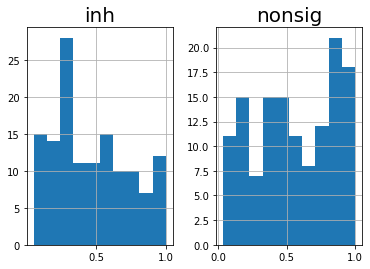

In [403]:
data.loc[data['has_sw_on']==True]['rank_pre_pct'][['inh','nonsig']].hist()

In [409]:
pyr_thresh = 0.5
data['pyr_g_thresh']=data.loc[:,(0,'pyr_norm')] > pyr_thresh

In [414]:
ma = data['pyr_g_thresh'] & np.logical_not(data['has_sw_on'])

array([[<Axes: title={'center': 'inh'}>,
        <Axes: title={'center': 'nonsig'}>]], dtype=object)

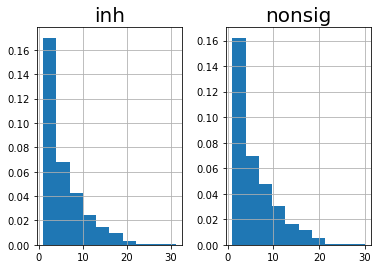

In [416]:
data.loc[ma]['rank_pre'][['inh','nonsig']].hist(density=True)



array([<Axes: title={'center': 'inh'}>], dtype=object)

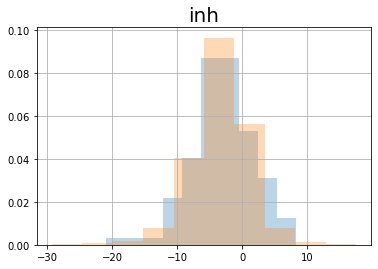

In [424]:
key_compare = 'diff_with_first'
fig,axs=plt.subplots(1,1)
ma = data['pyr_g_thresh'] & (data['has_sw_on'])
data.loc[ma][key_compare][['inh']].hist(density=True,ax=axs,alpha=0.3)

ma = data['pyr_g_thresh'] & np.logical_not(data['has_sw_on'])
data.loc[ma][key_compare][['inh']].hist(density=True,ax=axs,alpha=0.3)

<Axes: >

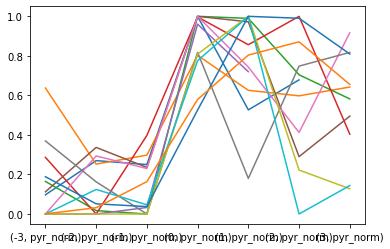

In [511]:
ma=(data['has_sw_on'])&data['clean'] & (data['diff_with_first']['inh'] > 0) 
data.loc[ma]

data.loc[ma].loc[:,(slice(None),'pyr_norm')].loc[:,-3:3].T.plot(legend=False)

In [516]:
ii=0

In [529]:
tt,uid,field_id,index_within=data.loc[ma].index[ii]
print(index_within)
fig,ax=plt.subplots()
ax.plot(X_raw.loc[ti,tt,uid,field_id].dropna().values,label='pyr',color='k',marker='o')
ax.legend()
ax2=ax.twinx()
intfr = int_fr_within_field_all.loc[('inh',ti,tt,uid,field_id),:].dropna().values
intfr_nonsig = int_fr_within_field_all.loc[('exc',ti,tt,uid,field_id),:].dropna().values
ax2.plot(intfr,label='int',color='green',marker='o')
ax2.plot(intfr_nonsig,label='exc',color='green',marker='o',linestyle=':')
ax2.legend()
ii+=1


IndexError: index 12 is out of bounds for axis 0 with size 12

In [479]:
data.loc[data['has_sw_on']]

-3                                                       \
                     all        exc        inh     nonsig       pyr  pyr_norm   
0.0  32  1 11  19.479226  27.585877  19.589717  14.954272  0.000000  0.000000   
     42  1 14  21.318473  21.861226  26.494404  19.637859  0.935291  0.067315   
         2 18  24.974993  31.516498  27.178650  20.418340  5.597020  0.275509   
     55  2 18  19.591916  24.074619  27.897373  15.925772  2.237622  0.162416   
     68  0 11  22.833163  24.449110  26.345239  21.943306  6.891992  0.472907   
...                  ...        ...        ...        ...       ...       ...   
both 279 0 14  22.797777  26.382604  22.767618  19.480086  6.216930  0.261861   
     283 0 11  23.224581  30.983733  24.514290  19.100839  0.000000  0.000000   
     349 0 2         NaN        NaN        NaN        NaN       NaN       NaN   
     354 0 5   27.457430  33.128778  29.076411  24.853389  0.005526  0.000378   
     370 0 24  22.395518  29.964851  27.836309  18.304162  0.863799  0.168008   

                      -2                                   ... rank_pre_pct  \
                     all        exc        inh     nonsig  ...          exc   
0.0  32  1 11  20.794135  27.108723  22.064412  16.558944  ...     1.000000   
     42  1 14  23.367764  26.473376  27.443160  20.414245  ...     0.200000   
         2 18  26.937424  34.562818  27.931204  22.036632  ...     0.842105   
     55  2 18  20.019612  25.136278  27.911541  16.140395  ...     0.894737   
     68  0 11  21.865910  24.255597  22.046499  21.051288  ...     0.083333   
...                  ...        ...        ...        ...  ...          ...   
both 279 0 14  22.420684  25.115908  21.406944  20.851299  ...     0.666667   
     283 0 11  25.949870  38.223842  25.309114  21.086253  ...     0.500000   
     349 0 2   26.951936  40.461610  20.857812  24.934628  ...     1.000000   
     354 0 5   27.259991  32.332102  32.313734  24.544756  ...     0.333333   
     370 0 24  22.302428  28.292268  29.567562  18.516728  ...     0.680000   

                                                has_sw_on  clean  \
                    inh    nonsig  pyr pyr_norm                    
0.0  32  1 11  0.916667  1.000000  1.0      1.0      True  False   
     42  1 14  0.666667  0.800000  1.0      1.0      True  False   
         2 18  0.736842  0.894737  1.0      1.0      True  False   
     55  2 18  0.315789  0.631579  1.0      1.0      True  False   
     68  0 11  0.416667  0.083333  1.0      1.0      True  False   
...                 ...       ...  ...      ...       ...    ...   
both 279 0 14  0.333333  0.333333  1.0      1.0      True  False   
     283 0 11  0.250000  0.083333  1.0      1.0      True  False   
     349 0 2   0.333333  0.333333  1.0      1.0      True  False   
     354 0 5   0.333333  0.166667  1.0      1.0      True  False   
     370 0 24  0.640000  0.800000  1.0      1.0      True  False   

              field_has_sw_on has_sw_off field_has_sw_off  
                                                           
0.0  32  1 11            True      False            False  
     42  1 14            True      False            False  
         2 18            True      False            False  
     55  2 18            True      False            False  
     68  0 11            True      False            False  
...                       ...        ...              ...  
both 279 0 14            True      False            False  
     283 0 11            True      False             True  
     349 0 2             True      False             True  
     354 0 5             True      False            False  
     370 0 24            True      False            False  

[133 rows x 101 columns]

In [477]:
data['clean']&data['has_sw_on']

0.0   31   1  0     False
              1     False
              2     False
              3     False
              4     False
                    ...  
both  376  0  27    False
              28    False
              29    False
              30    False
              31    False
Length: 14127, dtype: bool

In [474]:
data.loc[(data['has_sw_on'])&data['clean']]

Empty DataFrame
Columns: [(-3, all), (-3, exc), (-3, inh), (-3, nonsig), (-3, pyr), (-3, pyr_norm), (-2, all), (-2, exc), (-2, inh), (-2, nonsig), (-2, pyr), (-2, pyr_norm), (-1, all), (-1, exc), (-1, inh), (-1, nonsig), (-1, pyr), (-1, pyr_norm), (0, all), (0, exc), (0, inh), (0, nonsig), (0, pyr), (0, pyr_norm), (1, all), (1, exc), (1, inh), (1, nonsig), (1, pyr), (1, pyr_norm), (2, all), (2, exc), (2, inh), (2, nonsig), (2, pyr), (2, pyr_norm), (3, all), (3, exc), (3, inh), (3, nonsig), (3, pyr), (3, pyr_norm), (diff_with_first, all), (diff_with_first, exc), (diff_with_first, inh), (diff_with_first, nonsig), (diff_with_first, pyr), (diff_with_first, pyr_norm), (diff_with_mean_post, all), (diff_with_mean_post, exc), (diff_with_mean_post, inh), (diff_with_mean_post, nonsig), (diff_with_mean_post, pyr), (diff_with_mean_post, pyr_norm), (diff_with_mean_pre, all), (diff_with_mean_pre, exc), (diff_with_mean_pre, inh), (diff_with_mean_pre, nonsig), (diff_with_mean_pre, pyr), (diff_with_mean_pre, pyr_norm), (mean_post, all), (mean_post, exc), (mean_post, inh), (mean_post, nonsig), (mean_post, pyr), (mean_post, pyr_norm), (mean_pre, all), (mean_pre, exc), (mean_pre, inh), (mean_pre, nonsig), (mean_pre, pyr), (mean_pre, pyr_norm), (rank_post, all), (rank_post, exc), (rank_post, inh), (rank_post, nonsig), (rank_post, pyr), (rank_post, pyr_norm), (rank_post_pct, all), (rank_post_pct, exc), (rank_post_pct, inh), (rank_post_pct, nonsig), (rank_post_pct, pyr), (rank_post_pct, pyr_norm), (rank_pre, all), (rank_pre, exc), (rank_pre, inh), (rank_pre, nonsig), (rank_pre, pyr), (rank_pre, pyr_norm), (rank_pre_pct, all), (rank_pre_pct, exc), (rank_pre_pct, inh), (rank_pre_pct, nonsig), (rank_pre_pct, pyr), (rank_pre_pct, pyr_norm), (has_sw_on, ), (clean, ), (field_has_sw_on, ), (has_sw_off, ), ...]
Index: []

[0 rows x 101 columns]

<Axes: >

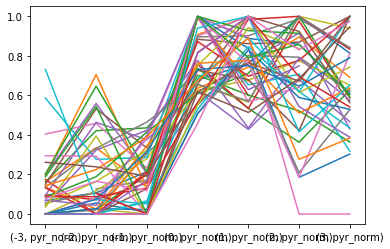

In [530]:
ma=(data['has_sw_on']) &data['clean']& (data['diff_with_first']['inh'] < 0)
data.loc[ma]

data.loc[ma].loc[:,(slice(None),'pyr_norm')].loc[:,-3:3].T.plot(legend=False)

array([[<Axes: title={'center': 'inh'}>,
        <Axes: title={'center': 'nonsig'}>]], dtype=object)

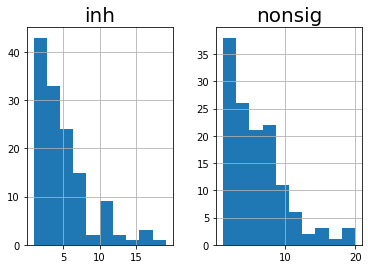

In [404]:
data.loc[data['has_sw_on']==True]['rank_pre'][['inh','nonsig']].hist()

In [390]:
[data.query("has_sw_on==@tf") for tf in [True,False]]

UndefinedVariableError: name 'has_sw_on' is not defined

In [383]:
data.groupby('has_sw_on')

In [362]:
data.groupby('has_sw_on').mean()['rank_pre_pct']

,all,exc,inh,nonsig,pyr,pyr_norm
has_sw_on,,,,,,
False,0.514953,0.544461,0.516635,0.523079,0.620424,0.620424
True,0.503905,0.539090,0.505351,0.496606,0.671592,0.671592


In [359]:
data.groupby('has_sw_off').mean()['rank_post_pct']

,all,exc,inh,nonsig,pyr,pyr_norm
has_sw_off,,,,,,
False,0.641342,0.626620,0.641611,0.634313,0.578158,0.578158
True,0.578028,0.638711,0.491768,0.561653,0.981391,0.981391


In [ ]:
data=copy.copy(consec_trial_fr_diff_all)


ti=0
all_sw_with_metrics_d_all_oneti = all_sw_with_metrics_d_all.loc[(slice(None),slice(None),ti),:]


clean = all_sw_with_metrics_d_all_oneti.apply(lambda x:x['pre_ntrial_ge_30_perc_frac_total'] < 0.3 if x['switch']==1 else x['post_ntrial_ge_30_perc_frac_total'] < 0.3,axis=1)
all_sw_with_metrics_d_all_oneti['clean'] = clean



onoff_str_d = {1:'on',-1:'off'}
for sw in [1,-1]:
    sw_data=all_sw_with_metrics_d_all_oneti.query('switch==@sw')
#     sw_data=all_sw_with_metrics_d_all_oneti.query('switch==@sw&clean==True')

    inds=[sw_data.index.get_level_values(0),
        sw_data.index.get_level_values(1),
        sw_data['trialtype'],sw_data['uid'],
        sw_data['field_index'],
        sw_data['switch_trial']-1,
         ]
    # for each switch trial, the reference trial should be the one before that


    inds=pd.MultiIndex.from_arrays(inds)


    onoff_str = onoff_str_d[sw]
    data[f'has_sw_{onoff_str}'] = False
    data.loc[inds,f'has_sw_{onoff_str}']=True
#     data['clean'] = False
#     data.loc[inds,f'clean'] = sw_data['clean']
    
    inds=[sw_data.index.get_level_values(0),
        sw_data.index.get_level_values(1),
        sw_data['trialtype'],sw_data['uid'],
        sw_data['field_index']]
    
    inds=pd.MultiIndex.from_arrays(inds)
    data[f'field_has_sw_{onoff_str}'] = False
    for ind in inds:
        data.loc[ind,f'field_has_sw_{onoff_str}']=True